# EHR Project Exploratory Data Analysis

_Note: For some reason `tensorflow-gpu` and `tensorflow-data-validation` are seemingly impossible to install together so this notebook is for the EDA/`tfdv` portions of the code that can run in a separate Anaconda environment._

In [33]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
# import tensorflow_data_validation as tfdv # blursed library
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import aequitas as ae

In [2]:
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)

# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [3]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
tf.config.list_physical_devices('GPU')

[]

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [5]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [7]:
len(df.encounter_id.unique())

101766

In [8]:
len(df)

143424

In [9]:
len(df.encounter_id.unique()) < len(df)

True

**Student Response:** We have more rows than unique `encounter_id` values so we have a line level dataset.

# Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


_Note: For EDA I used tensorflow data validation to guide a more in-depth look at some of the features._

### Missing or Zero Values

For this we look at any fields with zero values and any fields with `NaN` values. We also notice through exploration that `?` and `None` are used for missing values in many fields so we'll look at that as well.

In [10]:
remove_list = []

In [11]:
pczero = (df == 0).astype(int).sum() / len(df)
pczero[pczero > 0]

number_outpatient    0.836868
number_inpatient     0.674211
number_emergency     0.888582
num_procedures       0.458696
dtype: float64

In [12]:
pcna = df.isna().astype(int).sum() / len(df)
pcna[pcna > 0]

ndc_code    0.163585
dtype: float64

We have four fields with a large number of zero values and one field `ndc_code` with some `NaN` values. The `number_inpatient`, `number_outpatient`, and `number_emergency` fields track the number of inpatient, outpatient, and emergency procedures in the year before admission and based on the explanation of the features the zero values can reasonably be true zeros and not covering for missing values.

In [13]:
pcqm = df.applymap(lambda x: str(x) == '?').astype(int).sum() / len(df)
pcqm[pcqm > 0]

race                      0.023071
weight                    0.970005
payer_code                0.377831
medical_specialty         0.484319
primary_diagnosis_code    0.000230
dtype: float64

For `?` values we have `weight` which is 97% missing and so is probably useless. `medical_specialty` is next up with almost half of the values missing, it might be worth continuing to look at that column. `payer_code` has a large number of missing values and has the additional strike against it of appearing to be primarily billing related so possibly not even useful for our purposes. `race` and `primary_diagnosis_code` are the final two and have much smaller numbers of missing values so we can probably include as-is.

In [14]:
remove_list.extend(['weight', 'payer_code', 'medical_specialty'])

In [15]:
pcno = df.applymap(lambda x: str(x) == 'None').astype(int).sum() / len(df)
pcno[pcno > 0]

max_glu_serum    0.951089
A1Cresult        0.820295
dtype: float64

For `None` values it's a bit trickier because it's possible that `None` is a valid response (whereas `?` clearly represents an unknown/missing value). `A1Cresult` has 82% of its values listed as `None` and `max_glu_serum` has 95%. Barring other problems with these columns they are probably worth including. In a model with regularization should they not prove to be useful they will be shrunk down.

### Cardinality

Two approaches here: We look at the percentage of values that are unique relative to the entire length of the dataset, we also look at the naive mean category size (ie: how many observations are in the average category, smaller is worse, it's "naive" because we aren't considering the distribution at all).

In [16]:
len(df) * 0.01

1434.24

In [17]:
nun = df.apply(lambda x: len(x.unique()))
pcun = nun / len(df)
pcun[pcun > 0.10]

encounter_id             0.709547
patient_nbr              0.498647
other_diagnosis_codes    0.135082
dtype: float64

In [18]:
catsz = len(df) / nun
catsz[catsz < len(df) * 0.01]

encounter_id                 1.409351
patient_nbr                  2.005425
primary_diagnosis_code     200.033473
other_diagnosis_codes        7.402911
num_lab_procedures        1215.457627
ndc_code                   569.142857
dtype: float64

`encounter_id` and `patient_nbr` have the largest number of unique values. They are clearly UIDs so they aren't really meant for information purposes anyway and rather for grouping. `other_diagnosis_codes` also has a large number of values. Inspecting some we see that, as mentioned in the lessson, these are just different diagnosis codes smashed together. We could use these with feature engineering but as they are they probably aren't useful.

With much fewer unique values, but still high cardinality, we have `primary_diagnosis_code` which is probably worth keeping as it represents the most pressing diagnosis on that particular trip. `ndc_code` is a drug code which is debatably useful. As with `primary_diagnosis_code` there's probably too many values and most of them will be useless but there's a chance that a few specific codes will be important. Lastly `num_lab_procedures` seems (by the name) to be a numeric feature, which would explain the cardinality.

In [19]:
remove_list.extend(['other_diagnosis_codes', 'ndc_code'])

In [20]:
nun[catsz < len(df) * 0.01]

encounter_id              101766
patient_nbr                71518
primary_diagnosis_code       717
other_diagnosis_codes      19374
num_lab_procedures           118
ndc_code                     252
dtype: int64

### Distributions and Counts

We've made some preliminary judgments about some of the fields being UIDs now we need to look at the distributions and counts of the remaining features.

In [21]:
len(df.columns)

26

In [22]:
numeric = [
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id',
    'number_outpatient', 
    'number_inpatient', 
    'number_emergency', 
    'num_lab_procedures',
    'number_diagnoses',
    'num_medications',
    'num_procedures']

categorical = [
    'race',
    'gender',
    'age',
    'max_glu_serum',
    'A1Cresult',
    'change',
    'readmitted'
]

ids = [
    'encounter_id',
    'patient_nbr'
]

target = ['time_in_hospital']

other = [
    'other_diagnosis_codes',
    'primary_diagnosis_code',
    'ndc_code',
    'medical_specialty',
    'payer_code',
    'weight',
]

In [23]:
print(f"""
Numeric: {len(numeric)}
Categorical: {len(categorical)}
ID/Other: {len(other) + len(ids) + len(target)}
Total: {len(numeric) + len(categorical) + len(other) + len(ids) + len(target)}
""")


Numeric: 10
Categorical: 7
ID/Other: 9
Total: 26



In [24]:
len(df.columns)

26

In [25]:
from math import sqrt

def plt_multiple(df, features, barplot=False):
    square = int(sqrt(len(features))) + 1
    plt.figure(figsize=(16,16))
    
    for i in range(len(features)):
        plt.subplot(square, square, i+1)
        
        if barplot:
            x, y = np.unique(df[features[i]], return_counts=True)
            plt.title(features[i])
            plt.xticks(rotation=30)
            sns.barplot(x, y)
        else:
            sns.distplot(df[features[i]], bins=10)
            
    plt.show()
        

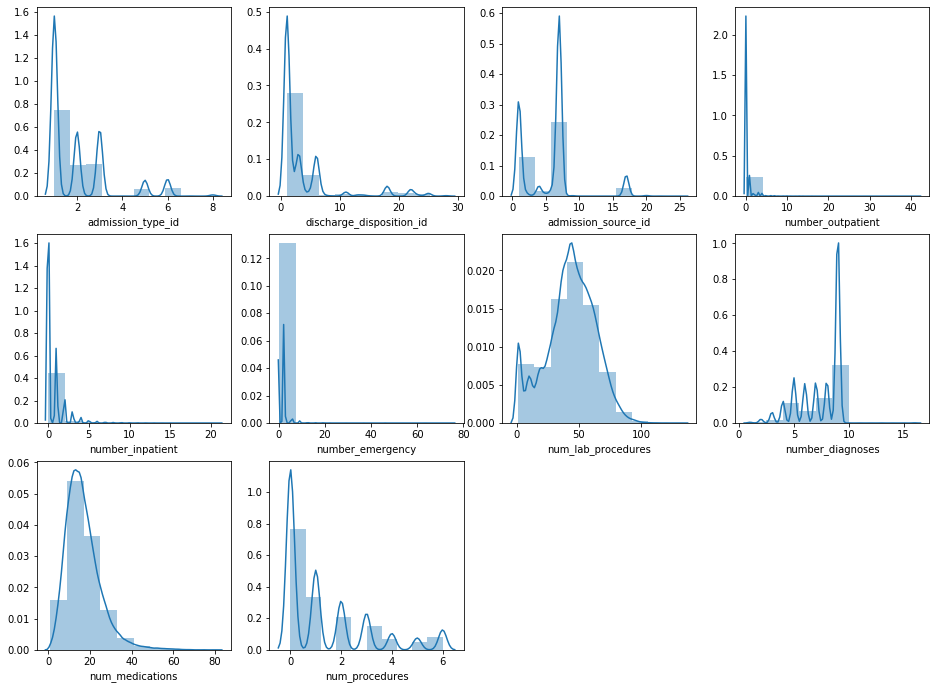

In [26]:
plt_multiple(df, numeric)

From this we see that `num_lab_procedures` and `num_medications` are both clearly normally distributed. `time_in_hospital` has a very skewed normal distribution. `number_inpatient`, `number_outpatient`, and `number_emergency` all seem seriously skewed. We know from above that the reason for this is the high number of zero values, we can also see from the range here that there are some extreme outliers in this set.

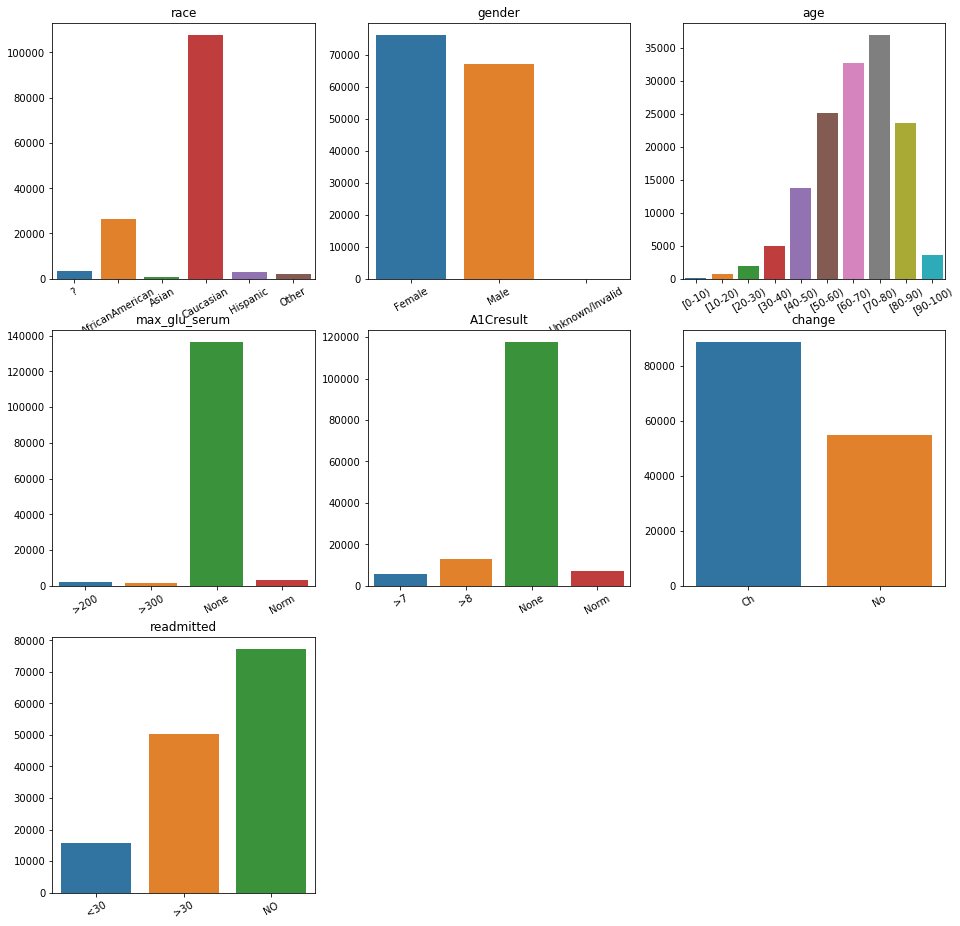

In [27]:
plt_multiple(df, categorical, barplot=True)

In terms of demographics our age group is skewed older than we would expect with the mode category being 70-80. Gender split is fairly equal with a skew towards women. As far as race there is a definite bias towards Caucasian, possibly too-much so, but we'd need to consider the population distribution as well. Regardless we will have a much smaller set of values when it comes to testing Asian and Hispanic populations which could bode poorly for generalizing across demographics.

In [28]:
x, y = np.unique(df.race, return_counts=True)
list(zip(x, y/len(df)))

[('?', 0.023071452476572957),
 ('AfricanAmerican', 0.18425786479250333),
 ('Asian', 0.006191432396251673),
 ('Caucasian', 0.7508366800535475),
 ('Hispanic', 0.020484716644355198),
 ('Other', 0.0151578536367693)]

### Pair Plots

First let's look at the questionably useful admission ids which are categorical features that we are currently treating as numeric.

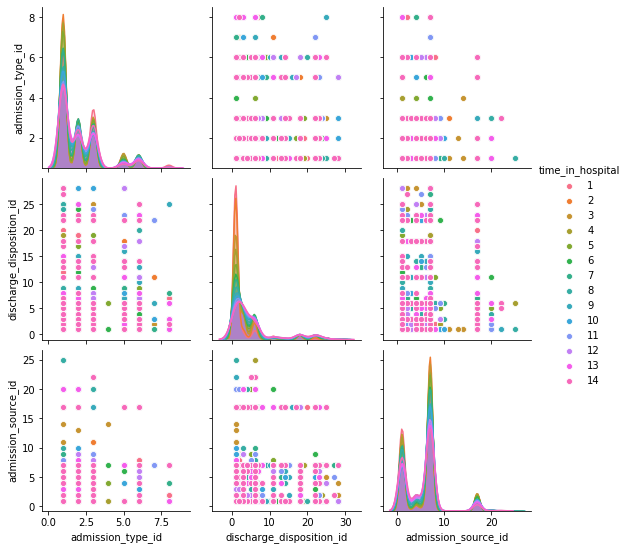

In [29]:
sns.pairplot(df[numeric[:3] + target], hue='time_in_hospital')

Treating these as numeric doesn't yield any kind of significant correlation. Next we'll look at the actual numeric features.

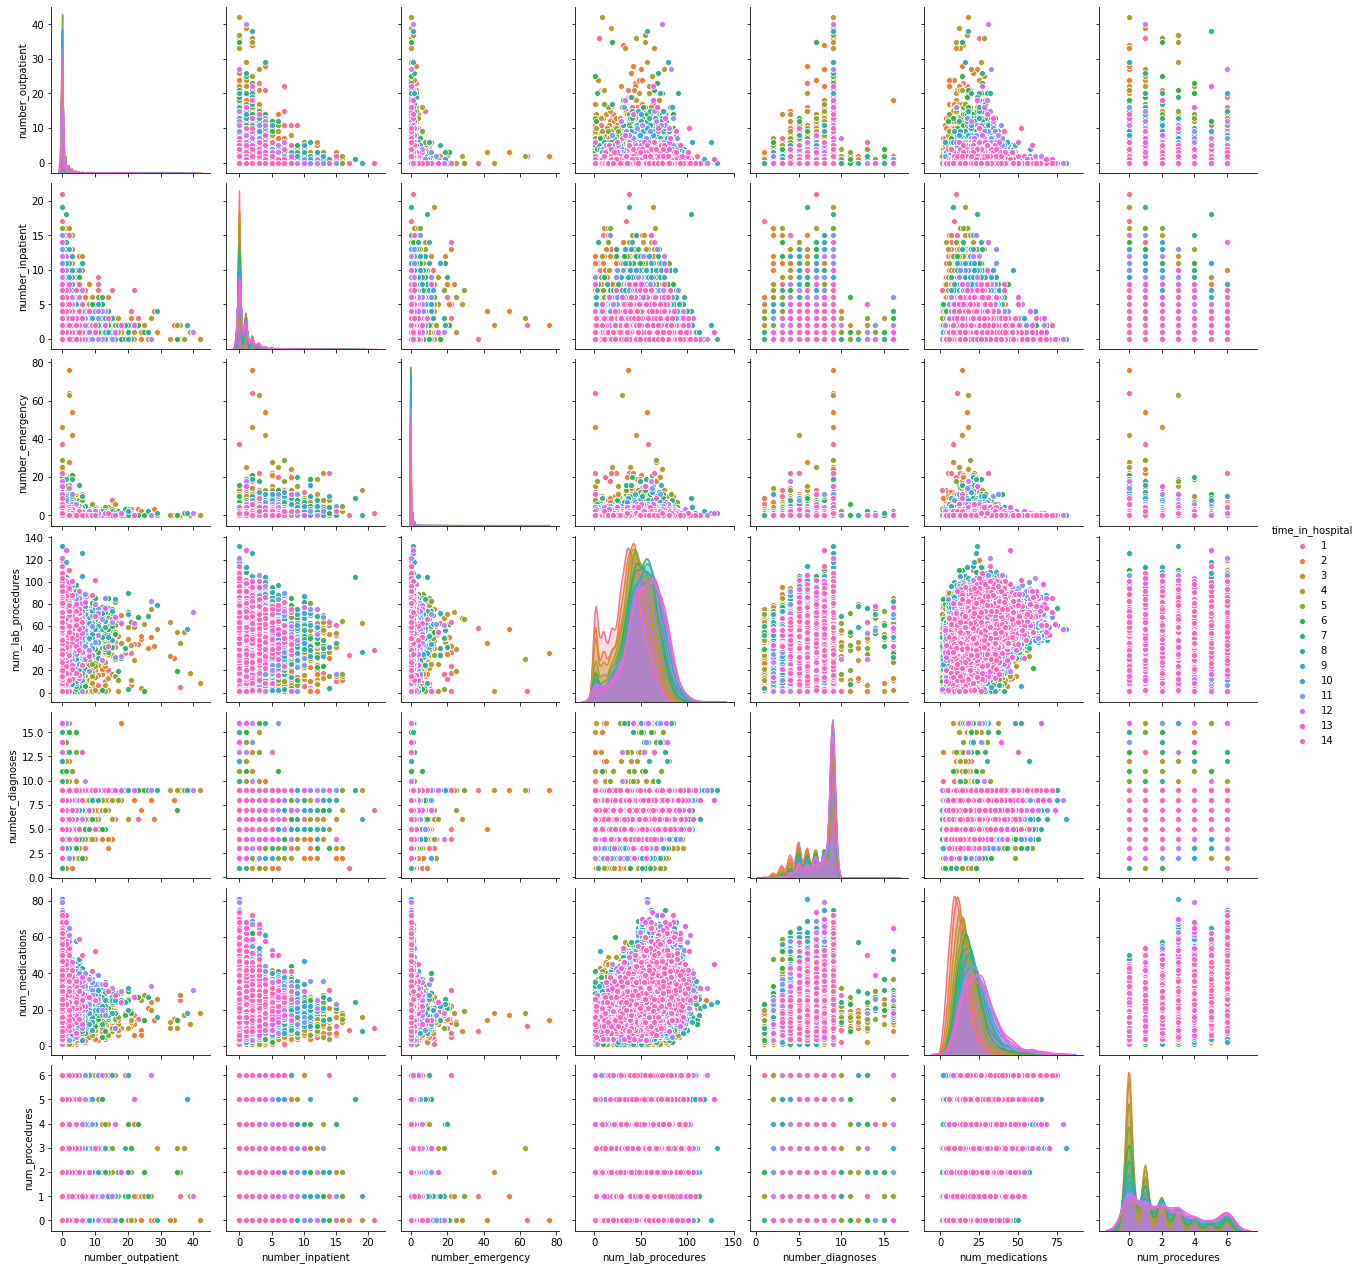

In [30]:
sns.pairplot(df[numeric[3:] + target], hue='time_in_hospital')

Seems somewhat easier to draw distinctions between the 7 or less days in the hospital groups and the more than 7 groups which suggests this might be better framed as a classification problem, but either way the data is pretty messy.

### Tensorflow Data Validation

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Note:** This worked once, and it was very useful, but getting `tensorflow-gpu` to work irrevocably broke it and the output disappeared and cannot be restored. Such is life. 

In [31]:
stats = tfdv.generate_statistics_from_dataframe(df)
tfdv.visualize_statistics(stats)

NameError: name 'tfdv' is not defined

In [ ]:
schema = tfdv.infer_schema(stats)
tfdv.display_schema(schema)